# Analyze all species pattern matches and their genomic positions

In [1]:
import pandas as pd 
import pyranges as pr
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import torch
from collections import OrderedDict
from plotnine import *

In [2]:
data_path = 'data'

In [ ]:
overlaps_dfs_list = []
all_species = ['agaricus_bisporus_var_burnettii_jb137_s8_gca_000300555', 'candida_albicans',  
               'debaryomyces_hansenii_cbs767_gca_000006445', 'kluyveromyces_lactis_gca_000002515', 
               'neurospora_crassa', 'saccharomyces_cerevisiae','schizosaccharomyces_pombe','yarrowia_lipolytica']

for species in all_species:
    df_path = os.path.join(data_path, f'{species}_top_hits_with_gtf_overlaps.tsv')
    #if df_path is not in the directory, skip it
    if not os.path.exists(df_path):
        continue
    print(df_path)
    overlaps_df = pd.read_csv(df_path, sep='\t')
    overlaps_df['species'] = species
    overlaps_dfs_list.append(overlaps_df)

overlapping_df = pd.concat(overlaps_dfs_list, axis=0).reset_index(drop=True)
overlapping_df

In [4]:
overlapping_df.columns

Index(['Chromosome', 'Start', 'End', 'conv_type', 'max_value',
       'downstream_gene_id', 'hit_x', 'Source', 'Feature', 'Start_y', 'End_y',
       'Score', 'Strand', 'Frame', 'gene_id', 'gene_source', 'gene_biotype',
       'transcript_id', 'transcript_source', 'transcript_biotype',
       'exon_number', 'exon_id', 'protein_id', 'processed_feature', 'Overlap',
       'seq_x', 'hit_y', 'seq_y', 'is_rev_complemment', 'frac_rev_complemment',
       'is_equal', 'frac_equal', 'rank', 'species', 'gene_name',
       'transcript_name'],
      dtype='object')

In [5]:
cowplot_theme = lambda figure_size, font_size: theme(
    # Set the background to white and remove panel border
    panel_background=element_blank(),
    panel_border=element_blank(),

    # Light grey grid lines
    panel_grid_major=element_line(color='lightgrey', size=0.5),
    panel_grid_minor=element_blank(),

    # Minimize axis ticks
    axis_ticks=element_blank(),
    #axis_text_x=element_text(rotation=45, hjust=1),

    # Simple font
    text=element_text(color='black', size=font_size),
    figure_size = figure_size
)

In [6]:
label_dict = {'five_prime_utr': '5\' UTR', 
              'three_prime_utr': '3\' UTR', 
              'tRNA_pseudogene': 'tRNA pseudogene', 
              'pseudogene_with_CDS': 'pseudogene with CDS', 
              'SRP_RNA': 'SRP RNA', 
              'transposable_element': 'transposable element', 
              'RNase_P_RNA': 'RNase P RNA', 
              'RNase_MRP_RNA': 'RNase MRP RNA'}
overlapping_anti_diag_filter_df = overlapping_df[overlapping_df['conv_type']=='anti_diag'].drop_duplicates(subset=['downstream_gene_id', 'processed_feature']).copy() # here we ensure we only have one upstream region and processed_feature per observation. 
#It can for example happen that an anti diagonal hit overlaps 2 exons which are in different strands (belong to 2 different genes). In this case the anti diag hit would map to both exons although it is in one location only.
#order processed_feature by median and make it categorical
overlapping_anti_diag_filter_df['processed_feature'] = pd.Categorical(overlapping_anti_diag_filter_df['processed_feature'], 
        categories=overlapping_anti_diag_filter_df.groupby('processed_feature')['max_value'].median().sort_values(ascending=False).index, ordered=True)
(ggplot(overlapping_anti_diag_filter_df, aes('processed_feature', 'max_value')) + geom_boxplot() + scale_x_discrete(labels=label_dict) +
        cowplot_theme+ labs(title='Anti-diagonal hits', x='', y='Max convolution value'))

AttributeError: 'function' object has no attribute '__radd__'

In [7]:
categories = {'five_prime_utr': 'Protein-coding\ngene', 
              'three_prime_utr': 'Protein-coding\ngene', 
              'tRNA_pseudogene': 'Structured\nRNA',  
              'tRNA': 'Structured\nRNA', 
              'intron': 'Protein-coding\ngene',
              'rRNA': 'Structured\nRNA', 
              'snRNA': 'Structured\nRNA', 
              'ribozyme': 'Structured\nRNA', 
              'pseudogene': 'Intergenic',
              'CDS':'Protein-coding\ngene',
              #'ncRNA': 'Intergenic &\n non-coding RNA',
              'pseudogene_with_CDS': 'Protein-coding\ngene', 
              'SRP_RNA': 'Structured\nRNA',   
              'snoRNA': 'Structured\nRNA',  
              'transposable_element': 'Intergenic', 
              'RNase_P_RNA': 'Structured\nRNA', 
              'RNase_MRP_RNA': 'Structured\nRNA',  
              'intergenic':'Intergenic'}

#replace the values of processed_feature with the categories dict mapping
overlapping_df = overlapping_df[overlapping_df['processed_feature']!='ncRNA'].copy()
overlapping_df['processed_feature'] = overlapping_df['processed_feature'].replace(categories)
overlapping_df['processed_feature'].unique()

array(['Structured\nRNA', 'Intergenic', 'Protein-coding\ngene'],
      dtype=object)

In [8]:
overlapping_anti_diag_filter_df = overlapping_df[overlapping_df['conv_type']=='anti_diag'].drop_duplicates(subset=['downstream_gene_id', 'processed_feature']).copy() # here we ensure we only have one upstream region and processed_feature per observation. 
#It can for example happen that an anti diagonal hit overlaps 2 exons which are in different strands (belong to 2 different genes). In this case the anti diag hit would map to both exons although it is in one location only.
#order processed_feature by median and make it categorical
overlapping_anti_diag_filter_df['processed_feature'] = pd.Categorical(overlapping_anti_diag_filter_df['processed_feature'], 
        categories=overlapping_anti_diag_filter_df.groupby('processed_feature')['max_value'].median().sort_values(ascending=False).index, ordered=True)

In [9]:
category_counts = overlapping_anti_diag_filter_df['processed_feature'].value_counts()

# Create new labels with counts
overlapping_anti_diag_filter_df['processed_feature'] = overlapping_anti_diag_filter_df['processed_feature'].apply(lambda x: f"{x}\nN={category_counts[x]}")

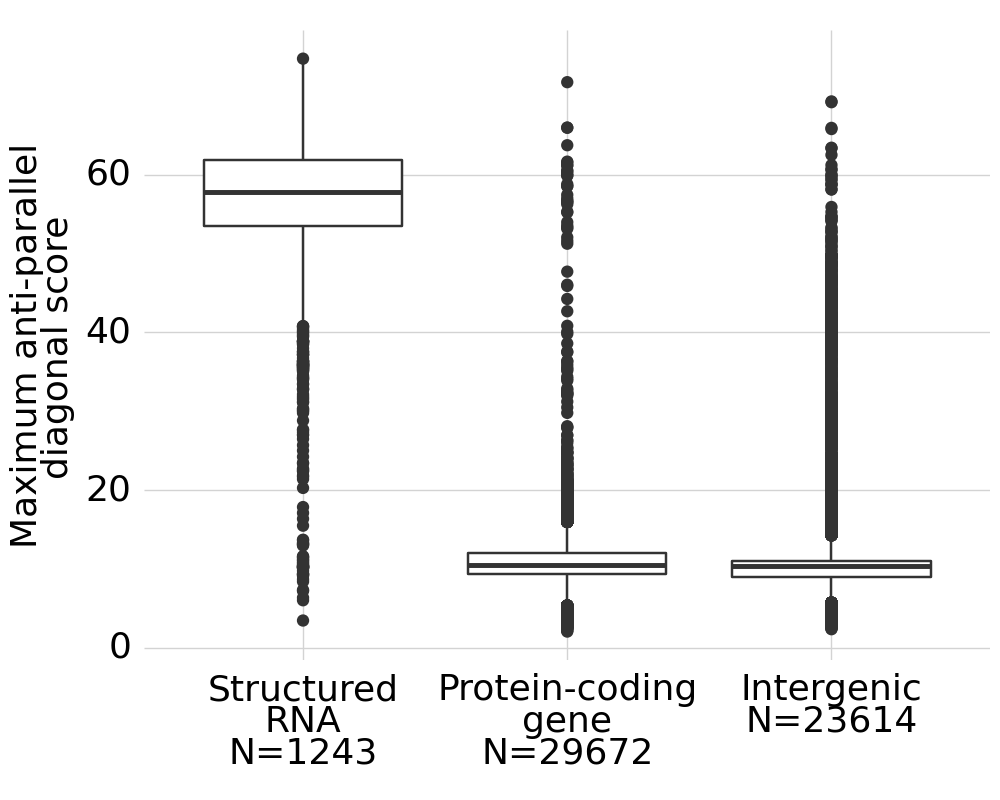

<Figure Size: (500 x 400)>

In [10]:
p = (ggplot(overlapping_anti_diag_filter_df, aes('processed_feature', 'max_value')) + geom_boxplot() +
        cowplot_theme(figure_size=(5,4), font_size=13)+ labs(x='', y='Maximum anti-parallel\n      diagonal score'))
p

In [ ]:
ggsave(p, "fig4_max_anti_par_per_region.png",  dpi=500)

## Anti-diagonal score vs fraction of base-pairing nucleotides 

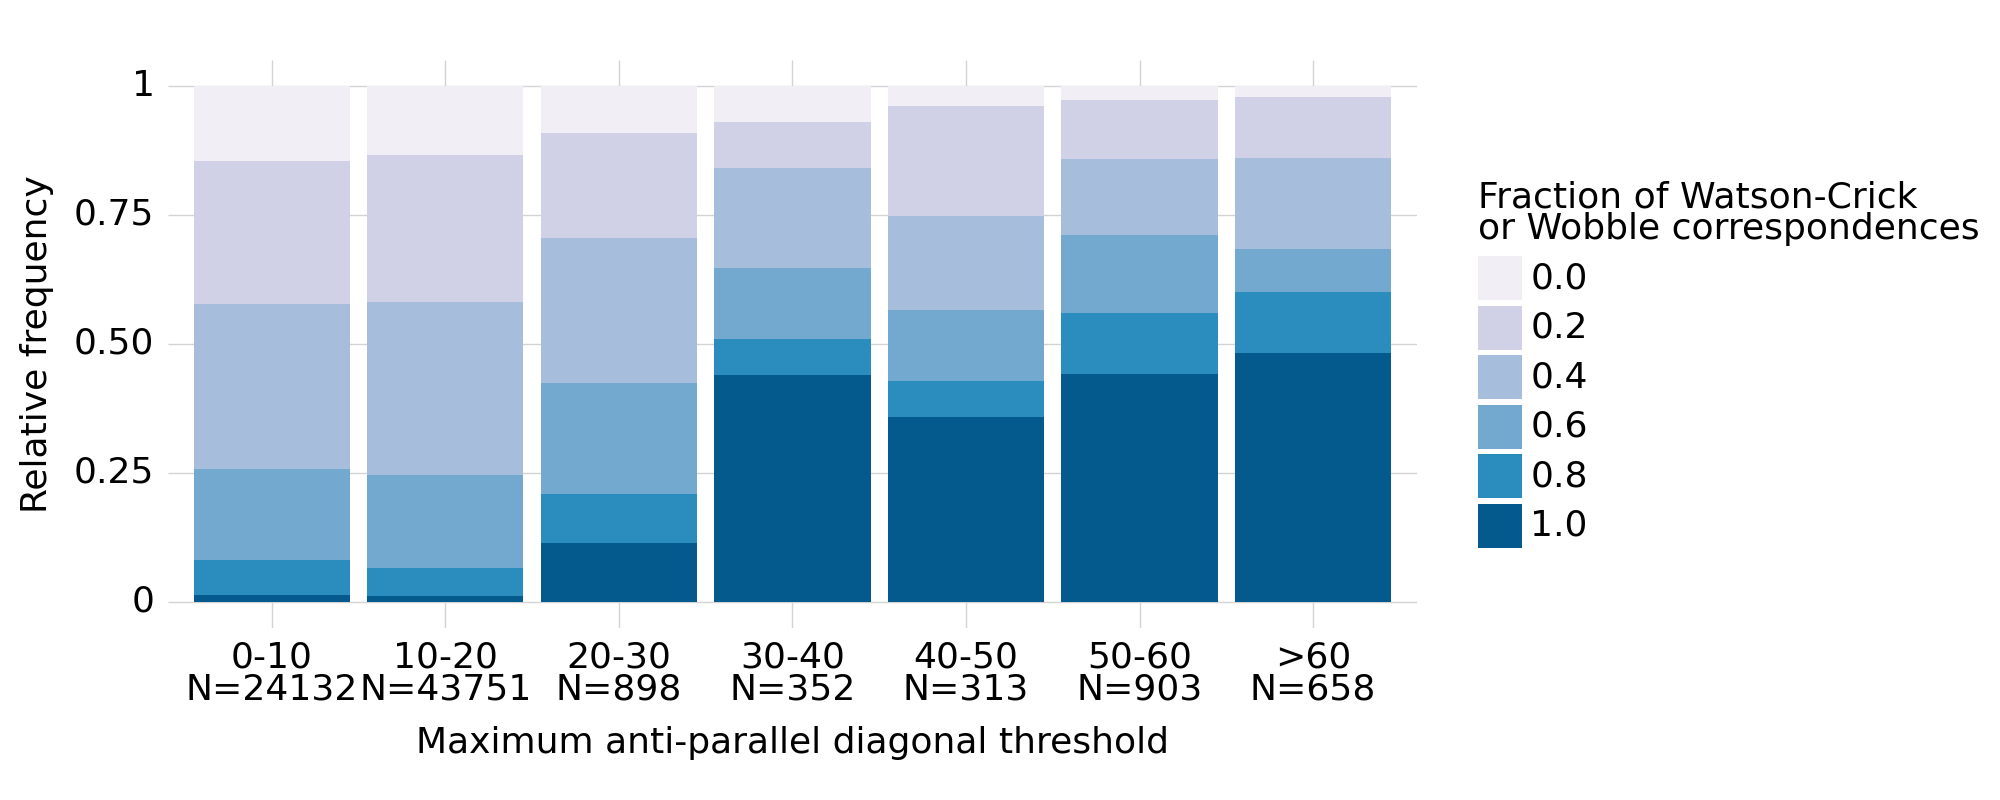

In [18]:
bins = [0, 10, 20, 30, 40, 50, 60, float('inf')]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '>60']
overlapping_df['max_conv_category'] = pd.cut(overlapping_df['max_value'], bins=bins, labels=labels, right=False)

category_counts = overlapping_df[overlapping_df['conv_type'] == 'anti_diag']['max_conv_category'].value_counts().sort_index()


labels_with_counts = [f'{label}\nN={category_counts[label]}' for label in labels]
overlapping_df['max_conv_category'] = pd.cut(overlapping_df['max_value'], bins=bins, labels=labels_with_counts, right=False)

# Step 4: Filter the dataframe for 'anti_diag' conv_type
filtered_df = overlapping_df[overlapping_df['conv_type'] == 'anti_diag']

p = (ggplot(filtered_df, aes(x='max_conv_category', fill='factor(frac_rev_complemment)')) + 
     geom_bar(position=position_fill()) +  # position_fill() makes the bars stack to show relative frequencies
     scale_fill_brewer( palette='PuBu') +  # Use a color palette for better visualization
     cowplot_theme(figure_size=(10, 4), font_size=13) + 
     labs(x='Maximum anti-parallel diagonal threshold', y='Relative frequency', fill='Fraction of Watson-Crick\nor Wobble correspondences\n'))

# Display the plot
print(p)

In [ ]:
ggsave(p, "fig4_rel_freq_max_antidiag_thresh.png",  dpi=500)

## Parallel diagonal score vs fraction of equal nucleotides 

In [20]:
overlapping_df[overlapping_df['conv_type'] == 'diag']

,Chromosome,Start,End,conv_type,max_value,downstream_gene_id,hit_x,Source,Feature,Start_y,...,seq_y,is_rev_complemment,frac_rev_complemment,is_equal,frac_equal,rank,species,gene_name,transcript_name,max_conv_category
10589,JH971390,1257427,1257432,diag,70.186870,AGABI1DRAFT_85329,972,-1,-1,-1,...,TTCAT,False,0.4,True,1.0,1,agaricus_bisporus_var_burnettii_jb137_s8_gca_0...,NaN,NaN,>60\nN=658
10590,JH971825,1095,1100,diag,65.258300,AGABI1DRAFT_133838,629,ena,CDS,1055,...,AAGAA,False,0.0,True,1.0,2,agaricus_bisporus_var_burnettii_jb137_s8_gca_0...,NaN,NaN,>60\nN=658
10591,JH971387,422167,422172,diag,64.668060,AGABI1DRAFT_35868,148,-1,-1,-1,...,TTCGT,False,0.4,True,1.0,3,agaricus_bisporus_var_burnettii_jb137_s8_gca_0...,NaN,NaN,>60\nN=658
10592,JH971413,65930,65935,diag,63.202496,AGABI1DRAFT_46435,100,-1,-1,-1,...,GTTAT,False,0.8,True,1.0,4,agaricus_bisporus_var_burnettii_jb137_s8_gca_0...,NaN,NaN,>60\nN=658
10593,JH971387,21635,21640,diag,62.736640,AGABI1DRAFT_125791,779,-1,-1,-1,...,ATGTC,False,0.0,True,1.0,5,agaricus_bisporus_var_burnettii_jb137_s8_gca_0...,NaN,NaN,>60\nN=658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269307,C,2862828,2862833,diag,2.481062,YALI0_C21406g,47,-1,-1,-1,...,TATAA,False,0.0,False,0.2,6399,yarrowia_lipolytica,-1,-1,0-10\nN=24132
269308,F,1940077,1940082,diag,2.463390,YALI0_F14509g,645,-1,-1,-1,...,AAGTT,False,0.6,False,0.8,6400,yarrowia_lipolytica,-1,-1,0-10\nN=24132
269309,B,1943310,1943315,diag,2.322841,YALI0_B14597g,352,-1,-1,-1,...,GAACC,False,0.4,False,0.2,6401,yarrowia_lipolytica,-1,-1,0-10\nN=24132
269310,A,1283338,1283343,diag,2.256427,YALI0_A12265g,270,ENA,CDS,1282611,...,TTGGG,False,0.8,False,0.6,6402,yarrowia_lipolytica,NaN,YALI0_A12243g-1,0-10\nN=24132


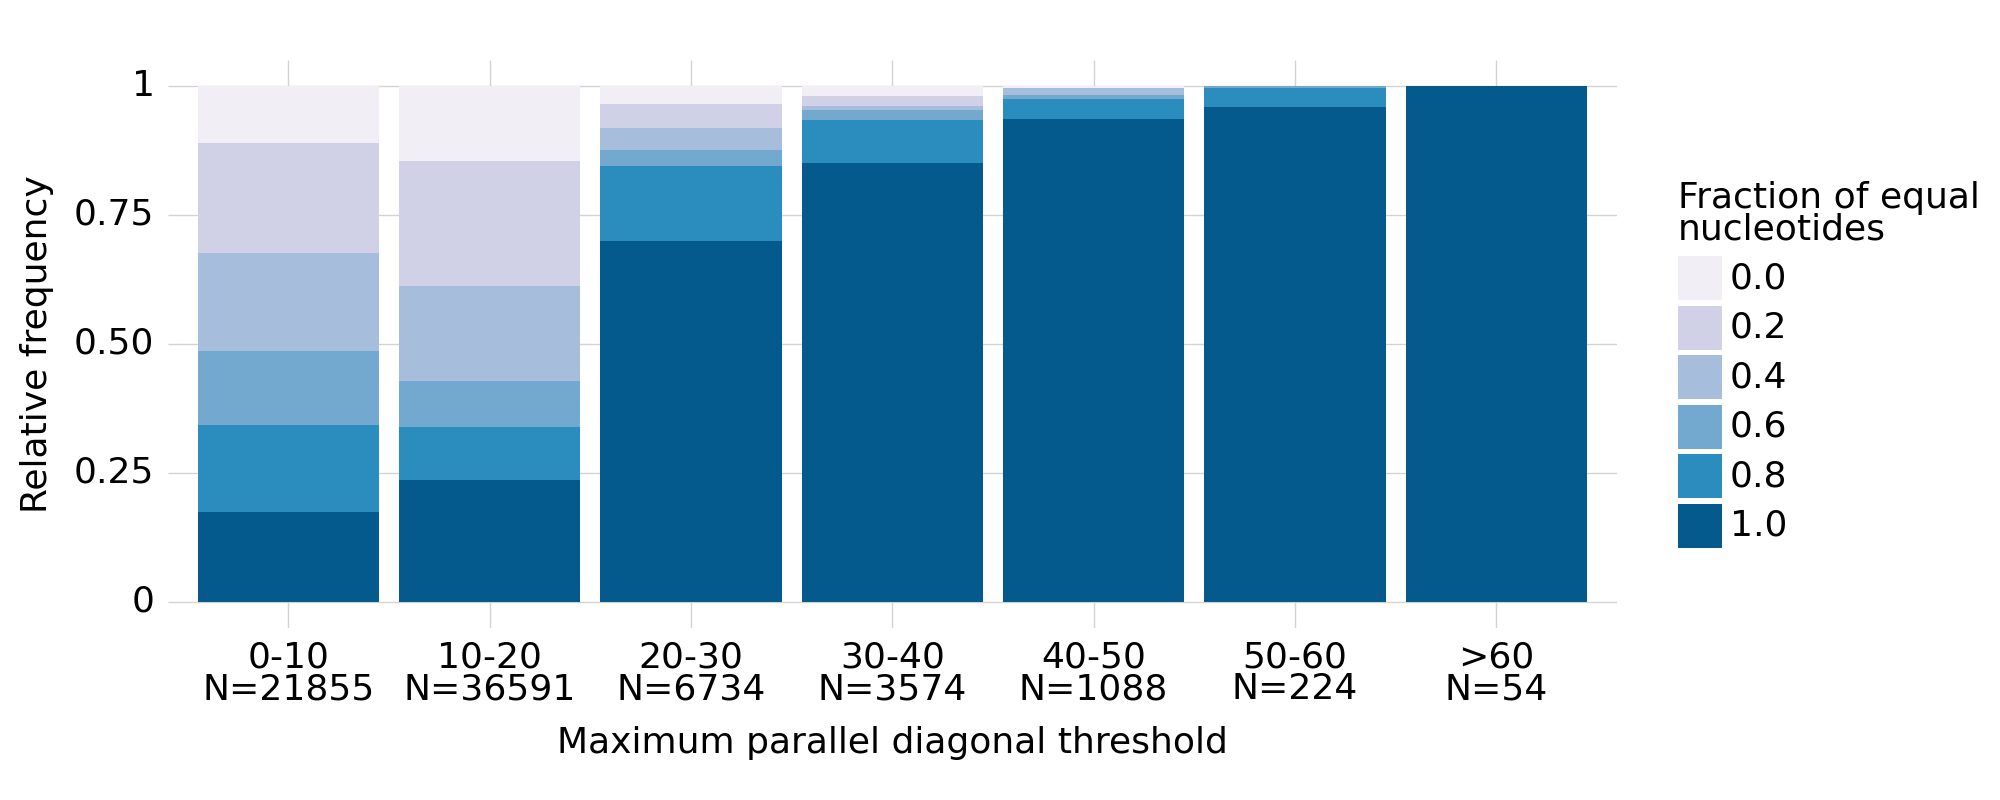

In [21]:
bins = [0, 10, 20, 30, 40, 50, 60, float('inf')]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '>60']
overlapping_df['max_conv_category'] = pd.cut(overlapping_df['max_value'], bins=bins, labels=labels, right=False)

category_counts = overlapping_df[overlapping_df['conv_type'] == 'diag']['max_conv_category'].value_counts().sort_index()


labels_with_counts = [f'{label}\nN={category_counts[label]}' for label in labels]
overlapping_df['max_conv_category'] = pd.cut(overlapping_df['max_value'], bins=bins, labels=labels_with_counts, right=False)

# Step 4: Filter the dataframe for 'anti_diag' conv_type
filtered_df = overlapping_df[overlapping_df['conv_type'] == 'diag']

p = (ggplot(filtered_df, aes(x='max_conv_category', fill='factor(frac_equal)')) + 
     geom_bar(position=position_fill()) +  # position_fill() makes the bars stack to show relative frequencies
     scale_fill_brewer( palette='PuBu') +  # Use a color palette for better visualization
     cowplot_theme(figure_size=(10, 4), font_size=13) + 
     labs(x='Maximum parallel diagonal threshold', y='Relative frequency', fill='Fraction of equal\nnucleotides\n'))

# Display the plot
print(p)

In [ ]:
ggsave(p, "fig6_rel_freq_max_diag_thresh.png",  dpi=500)